In [26]:
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [27]:
df = pd.read_csv('./Dataset/train10k.csv')
df.head()

,class_index,review_text
0,4,well-done film
1,1,characters ramble
2,3,the intensity that made her an interesting cha...
3,1,'s not really funny
4,2,stuffs


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  10000 non-null  int64 
 1   review_text  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

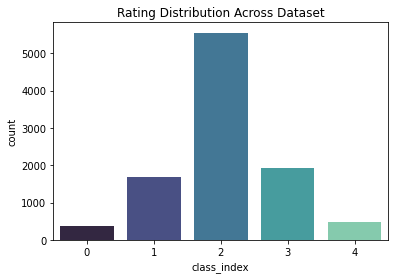

In [29]:
sns.countplot(data=df, x='class_index', palette='mako').set_title('Rating Distribution Across Dataset')

In [30]:
# Length of word in sentence
df['length'] = df['review_text'].apply(len)
df.head()

,class_index,review_text,length
0,4,well-done film,14
1,1,characters ramble,17
2,3,the intensity that made her an interesting cha...,66
3,1,'s not really funny,19
4,2,stuffs,6


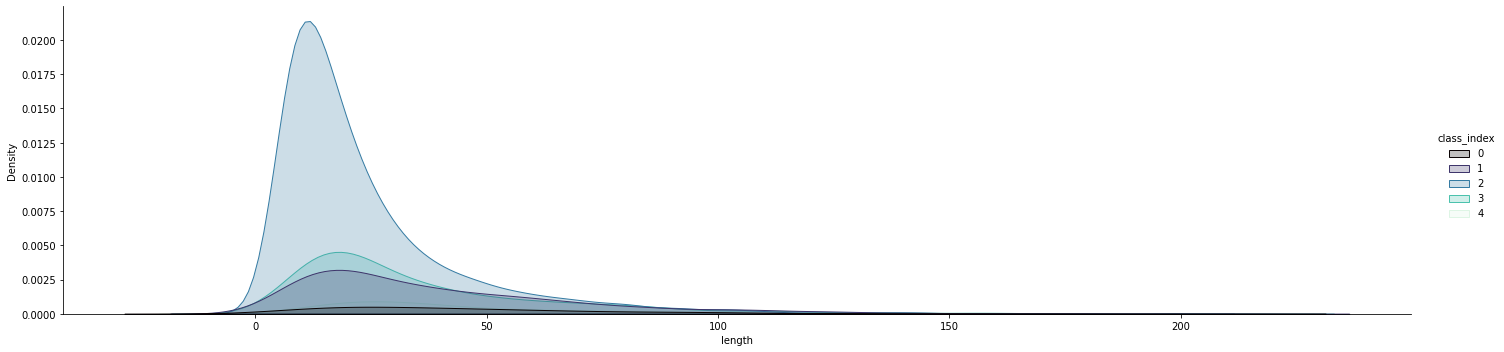

In [31]:
sns.displot(data=df, x='length', hue='class_index', palette='mako', kind='kde', fill=True, aspect=4)

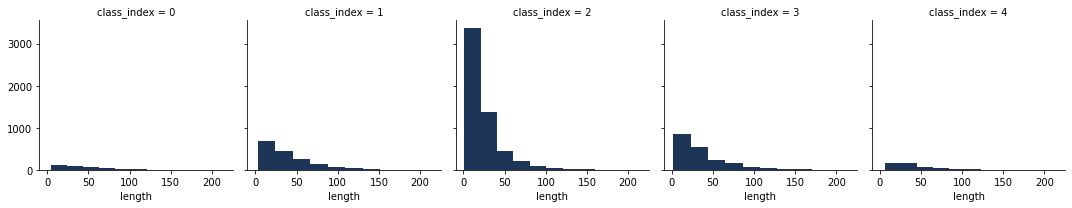

In [32]:
g = sns.FacetGrid(data=df, col='class_index')
g.map(plt.hist, 'length', color='#1D3557')

<AxesSubplot:xlabel='class_index', ylabel='length'>

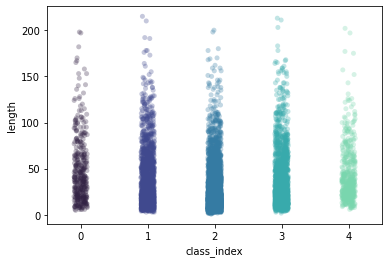

In [33]:
sns.stripplot(data=df, x='class_index', y='length', palette='mako', alpha=0.3)

Dari plot di atas kita dapat mengatakan bahwa semakin tinggi peringkat hotel, semakin besar kemungkinan pengunjung menulis ulasan yang panjang

In [34]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 2:
        return 'Good'
    elif score == 2:
        return 'Netral'
    else:
        return 'Bad'

In [35]:
df['class_index'] = df['class_index'].apply(rating)

In [36]:
df.head()

,class_index,review_text,length
0,Good,well-done film,14
1,Bad,characters ramble,17
2,Good,the intensity that made her an interesting cha...,66
3,Bad,'s not really funny,19
4,Netral,stuffs,6


In [37]:
# Total word in dataset before cleaning
length = df['length'].sum()

In [38]:
print('Original:')
print(df['review_text'][2])
print()

sentence = []
for word in df['review_text'][2].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['review_text'][2].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
the intensity that made her an interesting character to begin with

Stemming:
the intens that made her an interest charact to begin with

Lemmatization:
the intensity that make her an interest character to begin with


In [39]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [40]:
df['review_text'] = df['review_text'].apply(cleaning)

In [41]:
df['length'] = df['review_text'].apply(len)
new_length = df['length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 308063
Total word after cleaning: 214284


In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['review_text'], df['class_index'], test_size=0.3, random_state=0)

In [43]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [44]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [45]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10), n_jobs=-1).mean()
    accuracy.append(cross_val)

In [46]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.618429
1,RandomForestClassifier,0.638857
2,SVC,0.620143
3,LogisticRegression,0.623429
4,KNeighborsClassifier,0.569000
5,BernoulliNB,0.604000


In [47]:
log = RandomForestClassifier()
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [48]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 205   38  383]
 [  31  311  411]
 [  90  137 1394]]
              precision    recall  f1-score   support

         Bad       0.63      0.33      0.43       626
        Good       0.64      0.41      0.50       753
      Netral       0.64      0.86      0.73      1621

    accuracy                           0.64      3000
   macro avg       0.64      0.53      0.55      3000
weighted avg       0.64      0.64      0.61      3000



In [49]:
# RandomForestClassifier
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]
    
    return pred

In [50]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using RandomForestClassifier: {}'.format(ml_predict(text)))

Prediction using RandomForestClassifier: Good
